In [1]:
import torch.nn.functional as F
import torch.optim as optim
import torch
import torch.nn as nn
from model import GCN, MLP
from torch.utils.data import DataLoader
from gcn_utils import collate
from utils import get_data, get_data_for_mlp
from tqdm import tqdm



Using backend: pytorch
C:\Users\Yuan\AppData\Local\Continuum\anaconda3\lib\site-packages\dgl\base.py:25: UserWarning: Detected an old version of PyTorch. Suggest using torch>=1.2.0 for the best experience.
  warnings.warn(msg, warn_type)


In [9]:
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from gcn_utils import collate
from utils import get_data
from tqdm import tqdm

train_data = get_data('train_cv/fold_0/train.csv', device='cuda:0', no_h=False)
dev_data = get_data('train_cv/fold_0/dev.csv', device='cuda:0', no_h=False)
data_loader = DataLoader(train_data, batch_size=48, shuffle=True, collate_fn=collate)
_dev_data_loader = DataLoader(dev_data, batch_size=48, shuffle=False, collate_fn=collate)

Reading raw data ... : : 1694it [00:03, 480.60it/s]
Converting to DGL graphs ...: 100%|███████████████████████████████████████████████| 1694/1694 [00:12<00:00, 135.08it/s]
Reading raw data ... : : 202it [00:00, 421.93it/s]
Converting to DGL graphs ...: 100%|█████████████████████████████████████████████████| 202/202 [00:01<00:00, 110.86it/s]


In [10]:
NUM_ELEM = 27
EMBEDDING_DIM = 12
HIDDEN_DIM = 24
EDGE_HIDDEN_DIM = 6
NUM_CLS = 2
NUM_LYS = 2
ADD_ON_FEATS = 0 # 9
DROP_RT = 0.4

model = GCN(NUM_ELEM, EMBEDDING_DIM, HIDDEN_DIM, EDGE_HIDDEN_DIM, NUM_CLS, NUM_LYS, ADD_ON_FEATS, F.relu, DROP_RT)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

device = torch.device('cuda:0')
model.to(device)

for epoch in range(40):
    model.train()
    epoch_loss = 0
    batch = tqdm(data_loader)
    for bg, label in batch:
        optimizer.zero_grad()
        prediction = model(bg)
        loss = torch.mean(F.cross_entropy(prediction, label, reduction='none')
                         * (torch.ones_like(label, dtype=torch.float, device=device) +
                            torch.tensor(label.clone().detach(), dtype=torch.float, device=device) * 8))
        # loss = loss_func(prediction, label)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.detach().item()
        batch.set_description(f'epoch {epoch} loss {epoch_loss}')
    # if epoch > 10:
    #     print(F.softmax(prediction.detach()).cpu())
    #     print(label.cpu())
    dev_loss = 0
    if epoch % 10 == 9:
        model.eval()
        epoch_loss = 0
        dev_batch = tqdm(_dev_data_loader)
        all_pred = []
        all_label = []
        with torch.no_grad():
            for bg, label in dev_batch:
                prediction = model(bg)
                loss = loss_func(prediction, label)
                all_pred.append(F.softmax(prediction.clone().detach()))
                all_label.append(label.clone().detach())
                dev_loss += loss.detach().item()
                dev_batch.set_description(f'-DEV- epoch {epoch} loss {dev_loss}')


-DEV- epoch 39 loss 0.8274329416453838: 100%|████████████████████████████████████████████| 5/5 [00:00<00:00, 83.52it/s]


In [11]:
all_pred

[tensor([[0.9686, 0.0314],
         [0.9620, 0.0380],
         [0.9677, 0.0323],
         [0.9728, 0.0272],
         [0.9563, 0.0437],
         [0.9748, 0.0252],
         [0.9569, 0.0431],
         [0.9663, 0.0337],
         [0.9703, 0.0297],
         [0.9702, 0.0298],
         [0.9715, 0.0285],
         [0.9676, 0.0324],
         [0.9626, 0.0374],
         [0.9753, 0.0247],
         [0.9754, 0.0246],
         [0.9758, 0.0242],
         [0.9751, 0.0249],
         [0.9679, 0.0321],
         [0.9765, 0.0235],
         [0.9678, 0.0322],
         [0.9694, 0.0306],
         [0.9653, 0.0347],
         [0.9767, 0.0233],
         [0.9709, 0.0291],
         [0.9268, 0.0732],
         [0.9211, 0.0789],
         [0.9476, 0.0524],
         [0.9428, 0.0572],
         [0.9474, 0.0526],
         [0.9060, 0.0940],
         [0.9606, 0.0394],
         [0.9369, 0.0631],
         [0.9245, 0.0755],
         [0.9010, 0.0990],
         [0.8788, 0.1212],
         [0.8936, 0.1064],
         [0.8948, 0.1052],
 

In [12]:
all_label

[tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        device='cuda:0'),
 tensor([1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        device='cuda:0'),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        device='cuda:0'),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        device='cuda:0'),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')]

In [13]:
fpr = [0]
tpr = [0]
for dec_bound in [0.7,0.5, 0.4, 0.3,0.275, 0.25, 0.2375, 0.225, 0.2,0.175,0.15,0.1375,0.125,0.1125, 0.1,0.095,0.09,0.085, 0.08, 0.075, 0.0725, 0.07125, 0.07, 0.065, 0.06, 0.04, 0.02, 0.01, 0.005, 0.0025, 0.001, 0.0005, 0.00025, 0.0001, 0.00005,0.000005, 0]:
    t_p = []
    all_p = []
    f_p = []
    all_ins = []
    for pred, label in zip(all_pred, all_label):
        label_pred = pred.clone().detach()[:, 1] >= dec_bound * torch.ones_like(pred.clone().detach()[:, 1])
        # v, idx = torch.max(pred , dim=1)
        # print(idx)
        label_pred = (torch.tensor(label_pred.clone().detach(), dtype=torch.long, device=device))
        # print(label)
        t_p.append(sum(torch.tensor(label_pred == label, dtype=torch.long, device=device) * label).item())
        f_p.append(sum(torch.tensor(label_pred != label, dtype=torch.long, device=device) * torch.tensor(label == 0, dtype=torch.long, device=device)).item())

        all_p.append(sum(label).item())
        all_ins.append([*label.size()][0])

    print(f'{dec_bound} {sum(f_p)/sum(all_ins)} {sum(t_p)/sum(all_p)}')
    print()
    fpr.append(sum(f_p)/sum(all_ins))
    tpr.append(sum(t_p)/sum(all_p))
    # sum(all_ins)

C:\Users\Yuan\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
C:\Users\Yuan\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
C:\Users\Yuan\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app


0.7 0.0 0.07142857142857142

0.5 0.0 0.07142857142857142

0.4 0.0049504950495049506 0.21428571428571427

0.3 0.0049504950495049506 0.2857142857142857

0.275 0.0049504950495049506 0.42857142857142855

0.25 0.0049504950495049506 0.42857142857142855

0.2375 0.0049504950495049506 0.42857142857142855

0.225 0.0049504950495049506 0.42857142857142855

0.2 0.01485148514851485 0.42857142857142855

0.175 0.034653465346534656 0.42857142857142855

0.15 0.039603960396039604 0.5

0.1375 0.0594059405940594 0.5

0.125 0.06930693069306931 0.5

0.1125 0.10396039603960396 0.5714285714285714

0.1 0.12871287128712872 0.7142857142857143

0.095 0.14356435643564355 0.8571428571428571

0.09 0.15841584158415842 0.8571428571428571

0.085 0.18316831683168316 0.8571428571428571

0.08 0.19306930693069307 0.8571428571428571

0.075 0.22772277227722773 0.8571428571428571

0.0725 0.23267326732673269 0.8571428571428571

0.07125 0.24752475247524752 0.8571428571428571

0.07 0.2524752475247525 0.9285714285714286

0.065 0.2

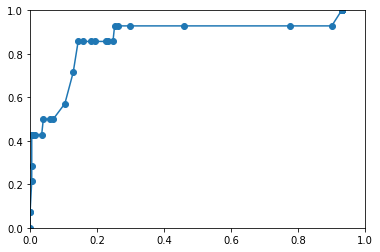

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(fpr, tpr, '-o')
plt.axis([0, 1, 0, 1])
plt.show()

In [15]:
a = 1 - fpr[-1]
for i in range(len(fpr)):
    if i == 0:
        pass
    else:
        a += tpr[i - 1] * (fpr[i] - fpr[i - 1])
a

0.8645685997171145

In [ ]:
56/1000


In [34]:
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from gcn_utils import collate
from utils import get_data
from tqdm import tqdm

train_data = get_data_for_mlp('train_cv/fold_0/train.csv', device='cuda:0', max_len=100, no_h=False)
dev_data = get_data_for_mlp('train_cv/fold_0/dev.csv', device='cuda:0', max_len=100, no_h=False)
data_loader = DataLoader(train_data, batch_size=32, shuffle=True)
_dev_data_loader = DataLoader(dev_data, batch_size=32, shuffle=False)


0it [00:00, ?it/s]
Reading raw data ... : : 0it [00:00, ?it/s]
Reading raw data ... : : 37it [00:00, 363.66it/s]
Reading raw data ... : : 87it [00:00, 394.43it/s]
Reading raw data ... : : 124it [00:00, 384.71it/s]
Reading raw data ... : : 165it [00:00, 388.93it/s]
Reading raw data ... : : 200it [00:00, 374.25it/s]
Reading raw data ... : : 248it [00:00, 400.00it/s]
Reading raw data ... : : 285it [00:00, 340.31it/s]
Reading raw data ... : : 329it [00:00, 361.72it/s]
Reading raw data ... : : 367it [00:00, 365.17it/s]
Reading raw data ... : : 404it [00:01, 363.68it/s]
Reading raw data ... : : 451it [00:01, 387.51it/s]
Reading raw data ... : : 497it [00:01, 404.90it/s]
Reading raw data ... : : 538it [00:01, 401.94it/s]
Reading raw data ... : : 579it [00:01, 397.60it/s]
Reading raw data ... : : 619it [00:01, 389.34it/s]
Reading raw data ... : : 668it [00:01, 413.13it/s]
Reading raw data ... : : 710it [00:01, 404.68it/s]
Reading raw data ... : : 751it [00:01, 394.87it/s]
Reading raw data ...

Extracting Features ...:   6%|███▏                                                  | 100/1694 [00:02<00:42, 37.18it/s]


Extracting Features ...:   9%|████▉                                                 | 153/1694 [00:04<00:52, 29.33it/s]


Extracting Features ...:  12%|██████▋                                               | 209/1694 [00:06<00:47, 31.39it/s]


Extracting Features ...:  16%|████████▌                                             | 267/1694 [00:08<00:55, 25.79it/s]


Extracting Features ...:  19%|██████████▎                                           | 324/1694 [00:09<00:39, 34.46it/s]


Extracting Features ...:  22%|████████████                                          | 379/1694 [00:11<00:40, 32.68it/s]


Extracting Features ...:  26%|█████████████▊                                        | 433/1694 [00:12<00:26, 48.42it/s]


Extracting Features ...:  29%|███████████████▋                                      | 491/1694 [00:14<00:31, 37.83it/s]


Extracting Features ...:  33%|█████████████████▌                                    | 551/1694 [00:15<00:32, 34.92it/s]


Extracting Features ...:  36%|███████████████████▎                                  | 604/1694 [00:17<00:41, 25.97it/s]


Extracting Features ...:  39%|█████████████████████▏                                | 663/1694 [00:19<00:27, 38.15it/s]


Extracting Features ...:  43%|███████████████████████                               | 722/1694 [00:20<00:27, 35.10it/s]


Extracting Features ...:  46%|████████████████████████▋                             | 776/1694 [00:22<00:40, 22.73it/s]


Extracting Features ...:  49%|██████████████████████████▍                           | 828/1694 [00:24<00:24, 34.78it/s]


Extracting Features ...:  53%|████████████████████████████▎                         | 890/1694 [00:25<00:13, 61.10it/s]


Extracting Features ...:  56%|██████████████████████████████▏                       | 947/1694 [00:26<00:09, 75.63it/s]


Extracting Features ...:  60%|███████████████████████████████▋                     | 1012/1694 [00:26<00:10, 66.28it/s]


Extracting Features ...:  63%|█████████████████████████████████▌                   | 1071/1694 [00:27<00:08, 71.98it/s]


Extracting Features ...:  67%|███████████████████████████████████▍                 | 1134/1694 [00:28<00:05, 94.81it/s]


Extracting Features ...:  70%|████████████████████████████████████▌               | 1190/1694 [00:29<00:04, 102.68it/s]


Extracting Features ...:  74%|██████████████████████████████████████▌             | 1255/1694 [00:29<00:04, 107.68it/s]


Extracting Features ...:  78%|█████████████████████████████████████████▍           | 1325/1694 [00:30<00:05, 65.53it/s]


Extracting Features ...:  82%|███████████████████████████████████████████▎         | 1384/1694 [00:32<00:10, 29.78it/s]


Extracting Features ...:  85%|████████████████████████████████████████████▉        | 1437/1694 [00:34<00:09, 25.89it/s]


Extracting Features ...:  88%|██████████████████████████████████████████████▋      | 1492/1694 [00:35<00:05, 34.20it/s]


Extracting Features ...:  91%|████████████████████████████████████████████████▍    | 1549/1694 [00:37<00:03, 36.57it/s]


Extracting Features ...:  95%|██████████████████████████████████████████████████▏  | 1606/1694 [00:39<00:03, 28.75it/s]


Extracting Features ...:  98%|███████████████████████████████████████████████████▉ | 1661/1694 [00:40<00:01, 27.87it/s]


Extracting Features ...: 100%|█████████████████████████████████████████████████████| 1694/1694 [00:41<00:00, 40.70it/s]
0it [00:00, ?it/s]
Reading raw data ... : : 0it [00:00, ?it/s]
Reading raw data ... : : 12it [00:00, 117.93it/s]
Reading raw data ... : : 50it [00:00, 148.22it/s]
Reading raw data ... : : 95it [00:00, 185.16it/s]
Reading raw data ... : : 133it [00:00, 217.80it/s]
Reading raw data ... : : 168it [00:00, 245.25it/s]
Reading raw data ... : : 202it [00:00, 334.23it/s]
Extracting Features ...:   9%|█████▎                                                  | 19/202 [00:00<00:05, 33.09it/s]


Extracting Features ...:  38%|█████████████████████▎                                  | 77/202 [00:02<00:03, 31.79it/s]


Extracting Features ...:  66%|████████████████████████████████████▏                  | 133/202 [00:03<00:01, 36.54it/s]


Extracting Features ...:  93%|███████████████████████████████████████████████████▏   | 188/202 [00:06<00:00, 29.30it/s]


Extracting Features ...: 100%|███████████████████████████████████████████████████████| 202/202 [00:06<00:00, 31.23it/s]

In [35]:
model = MLP(27 + 1, 16, 8, 48, 2, 3, 9, 100, 0.1)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

device = torch.device('cuda:0')
model.to(device)


MLP(
  (element_emebdding): Embedding(28, 16, padding_idx=0)
  (add_on_trans): Linear(in_features=9, out_features=8, bias=True)
  (layers): ModuleList(
    (0): Linear(in_features=24, out_features=48, bias=True)
    (1): Linear(in_features=48, out_features=48, bias=True)
    (2): Linear(in_features=48, out_features=48, bias=True)
  )
  (out): Linear(in_features=48, out_features=2, bias=True)
  (dropout): Dropout(p=0.1)
)

In [28]:
[train_data[i][-1].size() for i in range(len(train_data))]

[torch.Size([100, 9]),
 torch.Size([100, 9]),
 torch.Size([100, 9]),
 torch.Size([100, 9]),
 torch.Size([100, 9]),
 torch.Size([100, 9]),
 torch.Size([100, 9]),
 torch.Size([100, 9]),
 torch.Size([100, 9]),
 torch.Size([100, 9]),
 torch.Size([100, 9]),
 torch.Size([100, 9]),
 torch.Size([100, 9]),
 torch.Size([100, 9]),
 torch.Size([100, 9]),
 torch.Size([100, 9]),
 torch.Size([100, 9]),
 torch.Size([100, 9]),
 torch.Size([100, 9]),
 torch.Size([100, 9]),
 torch.Size([100, 9]),
 torch.Size([100, 9]),
 torch.Size([100, 9]),
 torch.Size([100, 9]),
 torch.Size([100, 9]),
 torch.Size([100, 9]),
 torch.Size([100, 9]),
 torch.Size([100, 9]),
 torch.Size([100, 9]),
 torch.Size([100, 9]),
 torch.Size([100, 9]),
 torch.Size([100, 9]),
 torch.Size([100, 9]),
 torch.Size([100, 9]),
 torch.Size([100, 9]),
 torch.Size([100, 9]),
 torch.Size([100, 9]),
 torch.Size([100, 9]),
 torch.Size([100, 9]),
 torch.Size([100, 9]),
 torch.Size([100, 9]),
 torch.Size([100, 9]),
 torch.Size([100, 9]),
 torch.Size

In [29]:
train_data[0]

(tensor([5, 1, 3, 1, 3, 5, 5, 3, 5, 5, 3, 5, 3, 5, 5, 5, 3, 5, 3, 5, 5, 3, 5, 5,
         3, 5, 3, 5, 3, 5, 5, 3, 5, 5, 3, 5, 3, 5, 5, 3, 5, 1, 5, 3, 5, 5, 3, 5,
         5, 3, 3, 5, 5, 5, 3, 5, 3, 5, 5, 3, 5, 5, 3, 3, 5, 5, 5, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0], device='cuda:0'),
 tensor(0, device='cuda:0'),
 tensor(67., device='cuda:0'),
 tensor([[1., 0., 1., 0., 0., 0., 1., 0., 1.],
         [0., 0., 0., 0., 0., 0., 1., 0., 1.],
         [1., 0., 0., 0., 0., 0., 1., 0., 1.],
         [0., 0., 0., 1., 0., 0., 0., 0., 1.],
         [0., 0., 0., 1., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 1., 0., 0., 0.],
         [0., 1., 0., 0., 0., 1., 0., 0., 0.],
         [0.

In [36]:
for epoch in range(40):
    model.train()
    epoch_loss = 0
    batch = tqdm(data_loader)
    for elem, label, lengths, feats in batch:
        optimizer.zero_grad()
        prediction = model(elem, lengths, feats)
        #loss = torch.mean(F.cross_entropy(prediction, label, reduction='none')
           #              * (torch.ones_like(label, dtype=torch.float, device=device) +
            #                torch.tensor(label.clone().detach(), dtype=torch.float, device=device) * 10))
        loss = loss_func(prediction, label)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.detach().item()
        batch.set_description(f'epoch {epoch} loss {epoch_loss}')
    # if epoch > 10:
    #     print(F.softmax(prediction.detach()).cpu())
    #     print(label.cpu())

    if epoch % 10 == 9:
        model.eval()
        epoch_loss = 0
        dev_batch = tqdm(_dev_data_loader)
        all_pred = []
        all_label = []
        with torch.no_grad():
            for elem, label, lengths, feats in dev_batch:
                prediction = model(elem, lengths, feats)
                loss = torch.mean(F.cross_entropy(prediction, label, reduction='none')
                                  * (torch.ones_like(label, dtype=torch.float, device=device) +
                                     torch.tensor(label.clone().detach(), dtype=torch.float, device=device) * 10))

                all_pred.append(F.softmax(prediction.clone().detach()))
                all_label.append(label.clone().detach())
                epoch_loss += loss.item()
                dev_batch.set_description(f'-DEV- epoch {epoch} loss {epoch_loss}')


epoch 1 loss 0.4752310663461685:   0%|                                                          | 0/53 [00:00<?, ?it/s]


epoch 2 loss 0.9913193266838789:  19%|█████████▏                                       | 10/53 [00:00<00:00, 97.35it/s]


epoch 3 loss 1.5575150065124035:  38%|██████████████████▍                              | 20/53 [00:00<00:00, 97.79it/s]


epoch 4 loss 2.6438135504722595:  38%|██████████████████▍                              | 20/53 [00:00<00:00, 95.98it/s]


epoch 5 loss 3.3078774698078632:  57%|███████████████████████████▋                     | 30/53 [00:00<00:00, 95.37it/s]


epoch 6 loss 3.67544162273407:  77%|███████████████████████████████████████▍           | 41/53 [00:00<00:00, 96.97it/s]


epoch 7 loss 4.234714042395353:  94%|███████████████████████████████████████████████▏  | 50/53 [00:00<00:00, 98.26it/s]


epoch 9 loss 0.21458712592720985:   0%|                                                         | 0/53 [00:00<?, ?it/s]


  0%|                                                                                            | 0/7 [00:00<?, ?it/s]C:\Users\Yuan\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
C:\Users\Yuan\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:33: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.

-DEV- epoch 9 loss 17.30309983715415:   0%|                                                      | 0/7 [00:00<?, ?it/s]


epoch 11 loss 0.4514108821749687:   0%|                                                         | 0/53 [00:00<?, ?it/s]


epoch 12 loss 0.6460581608116627:  19%|█████████                                       | 10/53 [00:00<00:00, 95.55it/s]


epoch 13 loss 1.545015312731266:  21%|██████████▏                                      | 11/53 [00:00<00:00, 99.21it/s]


epoch 14 loss 2.393002964556217:  38%|██████████████████▍                              | 20/53 [00:00<00:00, 97.11it/s]


epoch 15 loss 2.546326830983162:  60%|█████████████████████████████▌                   | 32/53 [00:00<00:00, 99.48it/s]


epoch 16 loss 3.58625416085124:  75%|█████████████████████████████████████▋            | 40/53 [00:00<00:00, 95.02it/s]


epoch 17 loss 3.906896060332656:  77%|█████████████████████████████████████▉           | 41/53 [00:00<00:00, 95.64it/s]


epoch 19 loss 0.14720135554671288:   0%|                                                        | 0/53 [00:00<?, ?it/s]


epoch 20 loss 0.09340614825487137:   0%|                                                        | 0/53 [00:00<?, ?it/s]


epoch 21 loss 0.8564857300370932:   0%|                                                         | 0/53 [00:00<?, ?it/s]


epoch 22 loss 1.2874604798853397:  21%|█████████▉                                      | 11/53 [00:00<00:00, 99.87it/s]


epoch 23 loss 2.199557200074196:  38%|██████████████████▍                              | 20/53 [00:00<00:00, 97.26it/s]


epoch 24 loss 1.9691307693719864:  57%|███████████████████████████▏                    | 30/53 [00:00<00:00, 97.61it/s]


epoch 25 loss 2.7628357652574778:  57%|███████████████████████████▏                    | 30/53 [00:00<00:00, 95.82it/s]


epoch 26 loss 3.0552545338869095:  75%|████████████████████████████████████▏           | 40/53 [00:00<00:00, 96.17it/s]


epoch 27 loss 3.860333278775215:  96%|███████████████████████████████████████████████▏ | 51/53 [00:00<00:00, 95.08it/s]


epoch 29 loss 0.1916481889784336:   0%|                                                         | 0/53 [00:00<?, ?it/s]


epoch 30 loss 0.10852321237325668:   0%|                                                        | 0/53 [00:00<?, ?it/s]


epoch 31 loss 0.8036237079650164:  19%|█████████                                       | 10/53 [00:00<00:00, 97.81it/s]


epoch 32 loss 0.9186436925083399:  19%|█████████                                       | 10/53 [00:00<00:00, 99.28it/s]


epoch 33 loss 1.2751376442611217:  38%|██████████████████                              | 20/53 [00:00<00:00, 97.23it/s]


epoch 34 loss 2.5714989732950926:  57%|███████████████████████████▏                    | 30/53 [00:00<00:00, 94.53it/s]


epoch 35 loss 2.222432531416416:  60%|█████████████████████████████▌                   | 32/53 [00:00<00:00, 99.42it/s]


epoch 36 loss 3.523099584504962:  81%|███████████████████████████████████████▊         | 43/53 [00:00<00:00, 99.87it/s]


epoch 38 loss 0.011694468557834625:   0%|                                                       | 0/53 [00:00<?, ?it/s]


epoch 39 loss 0.883330762386322:   0%|                                                          | 0/53 [00:00<?, ?it/s]


-DEV- epoch 39 loss 15.325979094952345: 100%|███████████████████████████████████████████| 7/7 [00:00<00:00, 226.43it/s]

In [37]:
fpr = [0]
tpr = [0]
for dec_bound in [0.7,0.5, 0.4, 0.3,0.275, 0.25, 0.2375, 0.225, 0.2,0.175,0.15,0.1375,0.125,0.1125, 0.1,0.095,0.09,0.085, 0.08, 0.075, 0.0725, 0.07125, 0.07, 0.065, 0.06, 0.04, 0.02, 0.01, 0.005, 0.0025, 0.00125, 0.000675, 0.00035, 0.000002]:
    t_p = []
    all_p = []
    f_p = []
    all_ins = []
    for pred, label in zip(all_pred, all_label):
        label_pred = pred.clone().detach()[:, 1] >= dec_bound * torch.ones_like(pred.clone().detach()[:, 1])
        # v, idx = torch.max(pred , dim=1)
        # print(idx)
        
        label_pred = (torch.tensor(label_pred.clone().detach(), dtype=torch.long, device=device))
        # print(label)
        t_p.append(sum(torch.tensor(label_pred == label, dtype=torch.long, device=device) * label).item())
        f_p.append(sum(torch.tensor(label_pred != label, dtype=torch.long, device=device) * torch.tensor(label == 0, dtype=torch.long, device=device)).item())

        all_p.append(sum(label).item())
        all_ins.append([*label.size()][0])

    print(f'{dec_bound} {sum(f_p)/sum(all_ins)} {sum(t_p)/sum(all_p)}')
    print()
    fpr.append(sum(f_p)/sum(all_ins))
    tpr.append(sum(t_p)/sum(all_p))
    # sum(all_ins)

C:\Users\Yuan\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]
C:\Users\Yuan\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
C:\Users\Yuan\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()


0.7 0.0 0.0

0.5 0.0 0.0

0.4 0.0 0.0

0.3 0.0 0.07142857142857142

0.275 0.0 0.14285714285714285

0.25 0.0 0.21428571428571427

0.2375 0.0 0.21428571428571427

0.225 0.0 0.21428571428571427

0.2 0.0049504950495049506 0.2857142857142857

0.175 0.0049504950495049506 0.2857142857142857

0.15 0.0049504950495049506 0.2857142857142857

0.1375 0.0049504950495049506 0.2857142857142857

0.125 0.0049504950495049506 0.35714285714285715

0.1125 0.009900990099009901 0.42857142857142855

0.1 0.009900990099009901 0.42857142857142855

0.095 0.009900990099009901 0.42857142857142855

0.09 0.009900990099009901 0.42857142857142855

0.085 0.01485148514851485 0.42857142857142855

0.08 0.01485148514851485 0.42857142857142855

0.075 0.01485148514851485 0.42857142857142855

0.0725 0.01485148514851485 0.42857142857142855

0.07125 0.01485148514851485 0.42857142857142855

0.07 0.01485148514851485 0.42857142857142855

0.065 0.01485148514851485 0.42857142857142855

0.06 0.019801980198019802 0.42857142857142855

0.

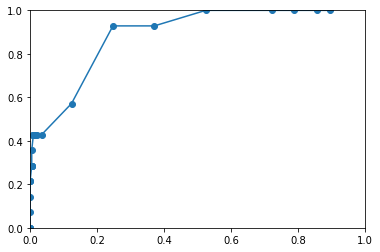

In [38]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(fpr, tpr, '-o')
plt.axis([0, 1, 0, 1])
plt.show()

In [39]:
a = 1 - fpr[-1]
for i in range(len(fpr)):
    if i == 0:
        pass
    else:
        a += tpr[i - 1] * (fpr[i] - fpr[i - 1])
a

0.8550212164073551